<a href="https://colab.research.google.com/github/msaddler/auditory_model_tutorial/blob/main/DEV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/msaddler/auditory_model_tutorial.git
%cd auditory_model_tutorial
!pwd

Cloning into 'auditory_model_tutorial'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 65 (delta 31), reused 47 (delta 17), pack-reused 0 (from 0)
Receiving objects: 100% (65/65), 7.88 MiB | 9.29 MiB/s, done.
Resolving deltas: 100% (31/31), done.
/content/auditory_model_tutorial
/content/auditory_model_tutorial


In [2]:
import importlib
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import torch
import tqdm
import soundfile as sf

import utils
import filters
import modules

importlib.reload(utils)
importlib.reload(filters)
importlib.reload(modules)

device = "cpu"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device


device(type='cuda', index=0)

In [3]:
sr = 20e3
x = utils.harmonic_complex_tone(
    sr=sr,
    dur=0.5,
    f0=220,
    phase="sine",
    harmonics=np.arange(1, 11),
    amplitudes=0.02,
)

ipd.display(ipd.Audio(rate=sr, data=x))


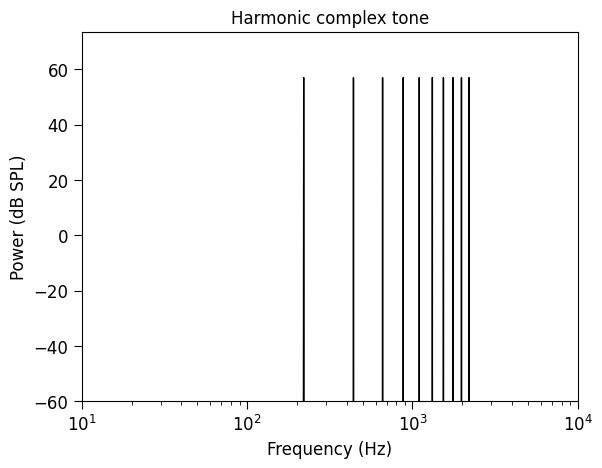

In [4]:
fig, ax = plt.subplots()
fxx, pxx = utils.periodogram(x, sr=sr, scaling="spectrum")
ax.plot(fxx, pxx, color="k", lw=1)
ax = utils.format_axes(
    ax,
    str_title="Harmonic complex tone",
    str_xlabel="Frequency (Hz)",
    str_ylabel="Power (dB SPL)",
    xscale="log",
    yscale="linear",
    xlimits=[10, sr / 2],
    ylimits=[-60, None],
)
plt.show()

# fig, ax = utils.make_periodogram_plot(x, sr, str_title="Harmonic complex tone")
# plt.show()


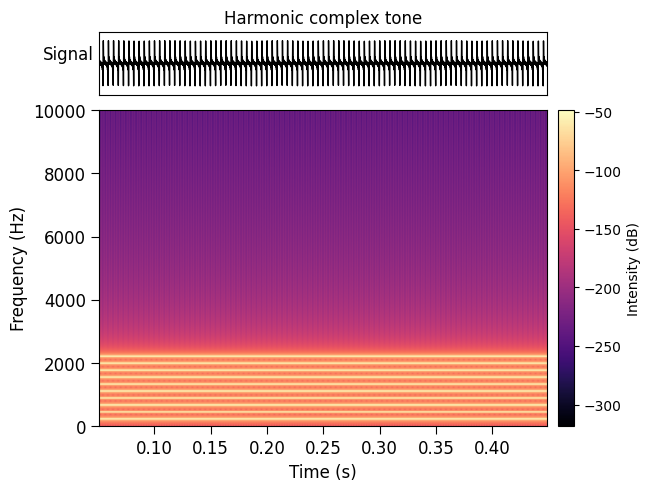

In [5]:
utils.make_spectrogram_plot(
    x,
    sr,
    nfft=2048,
    # ylimits=[0, 4e3],
    str_title="Harmonic complex tone",
)
plt.show()


(50, 20000)


/content/auditory_model_tutorial/utils.py:99: RuntimeWarning: divide by zero encountered in log10
  pxx = 10.0 * np.log10(pxx / np.square(p_ref))


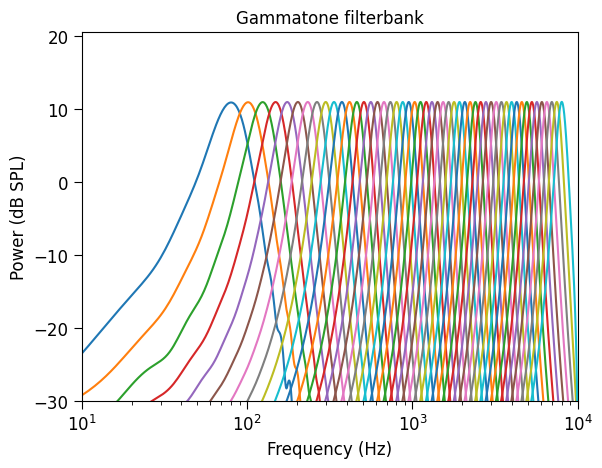

In [6]:
filterbank = modules.GammatoneFilterbank(
    sr=sr,
    fir_dur=0.05,
    cfs=utils.erbspace(8e1, 8e3, 50),
    dtype=torch.float32,
    bw_mult=1,
).to(device)

impulse = np.zeros(int(sr * 1.0))
impulse[0] = 1.0
impulse_tensor = torch.as_tensor(impulse, device=device, dtype=torch.float32).unsqueeze(0)
impulse_response_tensor = filterbank(impulse_tensor).squeeze(0)
impulse_response = impulse_response_tensor.detach().cpu().numpy()
print(impulse_response.shape)

fig, ax = utils.make_periodogram_plot(
    impulse_response,
    sr,
    str_title="Gammatone filterbank",
    ylimits=[-30, None],
)
plt.show()


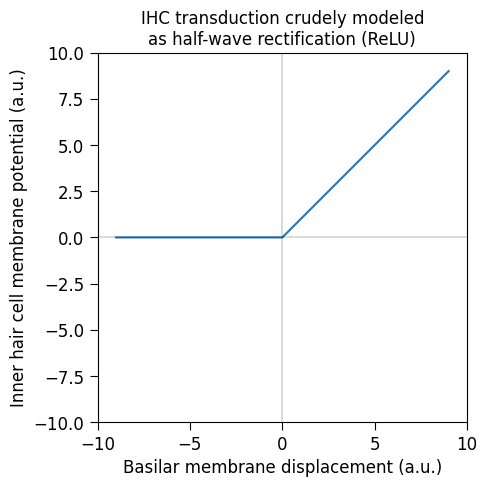

In [7]:
half_wave_rectification = torch.nn.ReLU()
x = np.arange(-9, 10)
y = half_wave_rectification(torch.as_tensor(x)).detach().cpu().numpy()

fig, ax = plt.subplots()
ax.plot(x, y)
ax.axvline(0, color="k", lw=0.2)
ax.axhline(0, color="k", lw=0.2)
ax.axis("square")
utils.format_axes(
    ax,
    xlimits=[-10, 10],
    ylimits=[-10, 10],
    str_xlabel="Basilar membrane displacement (a.u.)",
    str_ylabel="Inner hair cell membrane potential (a.u.)",
    str_title="IHC transduction crudely modeled\nas half-wave rectification (ReLU)",
)
plt.show()


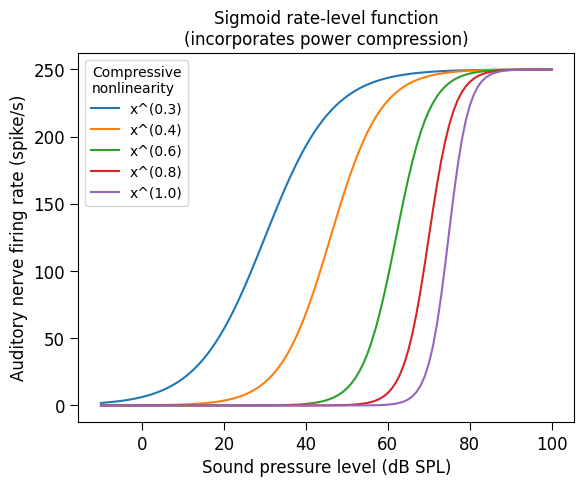

In [8]:
fig, ax = plt.subplots()
for compression_power in [0.3, 0.4, 0.6, 0.8, 1.0]:
    rate_level_function = modules.SigmoidRateLevelFunction(
        rate_spont=0.0,
        rate_max=250.0,
        threshold=0.0,
        dynamic_range=60.0,
        dynamic_range_interval=0.95,
        compression_power_default=0.3,
        compression_power=compression_power,
        dtype=torch.float32,
    ).to(device)
    x_db = np.arange(-10, 101)
    x_pa = 20e-6 * (10 ** (x_db / 20))
    x_pa_tensor = torch.as_tensor(
        x_pa,
        device=device,
        dtype=torch.float32,
    )
    y_tensor = rate_level_function(x_pa_tensor[None, None, :])[0, 0, :]
    y = y_tensor.detach().cpu().numpy()
    ax.plot(
        x_db,
        y,
        label="x^({:.1f})".format(compression_power),
    )
ax.legend(title="Compressive\nnonlinearity")
ax = utils.format_axes(
    ax,
    str_xlabel="Sound pressure level (dB SPL)",
    str_ylabel="Auditory nerve firing rate (spike/s)",
    str_title="Sigmoid rate-level function\n(incorporates power compression)",
)
plt.show()


(20000,)


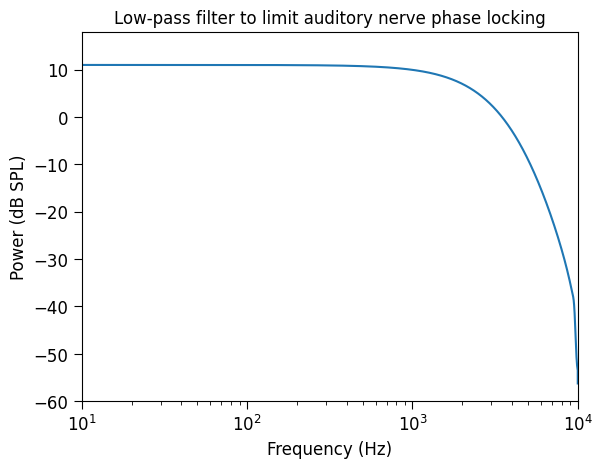

In [9]:
filterbank = modules.IHCLowpassFilter(
    sr_input=sr,
    sr_output=sr,
    fir_dur=0.05,
    cutoff=3e3,
    order=7,
).to(device)

impulse = np.zeros(int(sr * 1.0))
impulse[0] = 1.0
impulse_tensor = torch.as_tensor(impulse, device=device, dtype=torch.float32).unsqueeze(0)
impulse_response_tensor = filterbank(impulse_tensor).squeeze(0)
impulse_response = impulse_response_tensor.detach().cpu().numpy()
print(impulse_response.shape)

fig, ax = utils.make_periodogram_plot(
    impulse_response,
    sr,
    str_title="Low-pass filter to limit auditory nerve phase locking",
)
plt.show()


(100, 500)


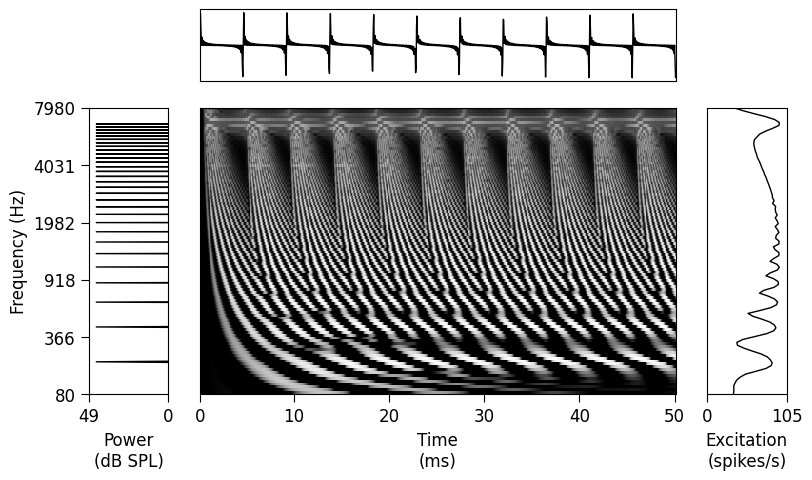

In [10]:
class CochlearModel(torch.nn.Module):
    def __init__(
        self,
        sr_input=20000,
        sr_output=10000,
        cfs=utils.erbspace(8e1, 8e3, 100),
        bw_mult=1.0,
        compression_power=0.3,
        threshold=0.0,
    ):
        """
        Simple cochlear model.

        Args
        ----
        sr_input (int): sampling rate of the input sound waveform
        sr_output (int): sampling rate of the output representation
        cfs (np.ndarray): characteristic frequencies of the cochlear filters
        bw_mult (float): scales cochlear filter bandwidths
        compression_power (float): power of the compression applied to filterbank outputs
        threshold (float): absolute threshold in dB SPL of auditory nerve fibers
        """
        super().__init__()
        self.sr_input = sr_input
        self.sr_output = sr_output
        self.cfs = cfs
        self.cochlear_filterbank = modules.GammatoneFilterbank(
            sr=sr_input,
            fir_dur=0.05,
            cfs=self.cfs,
            dtype=torch.float32,
            bw_mult=bw_mult,
        )
        self.half_wave_rectification = torch.nn.ReLU()
        self.rate_level_function = modules.SigmoidRateLevelFunction(
            rate_spont=0.0,
            rate_max=250.0,
            threshold=threshold,
            dynamic_range=60.0,
            dynamic_range_interval=0.95,
            compression_power_default=0.3,
            compression_power=compression_power,
            dtype=torch.float32,
        )
        self.ihc_lowpass_filter = modules.IHCLowpassFilter(
            sr_input=sr_input,
            sr_output=sr_output,
            fir_dur=0.05,
            cutoff=3e3,
            order=7,
        )

    def forward(self, x):
        """
        Run the cochlear model on an input sound waveform.

        Args
        ----
        x (torch.Tensor): input sound waveform with shape [batch, time]

        Returns
        -------
        x (torch.Tensor): output of cochlear model with shape [batch, freq, time]
        """
        x = self.cochlear_filterbank(x)
        x = self.half_wave_rectification(x)
        x = self.rate_level_function(x)
        x = self.ihc_lowpass_filter(x)
        x = self.half_wave_rectification(x)
        return x


cochlear_model = CochlearModel(
    sr_input=sr,
    cfs=utils.erbspace(8e1, 8e3, 100),
).to(device)

x = utils.harmonic_complex_tone(
    sr=cochlear_model.sr_input,
    dur=0.05,
    f0=220,
    phase="sine",
    harmonics=np.arange(1, 31, 1),
)
# x = sf.read("data/000.wav")[0]
x = utils.set_dbspl(x, 60)

x_tensor = torch.as_tensor(x, device=device).float()[None, ...]
x_nervegram_tensor = cochlear_model(x_tensor)[0]
x_nervegram = x_nervegram_tensor.detach().cpu().numpy()
print(x_nervegram.shape)

fig, ax_arr = utils.make_nervegram_plot(
    # figsize=(12, 5),
    waveform=x,
    nervegram=x_nervegram,
    sr_waveform=cochlear_model.sr_input,
    sr_nervegram=cochlear_model.sr_output,
    cfs=cochlear_model.cfs,
)
plt.show()


In [11]:
for _ in tqdm.tqdm(range(20)):
    cochlear_model(x_tensor)


100%|██████████| 20/20 [00:00<00:00, 1328.55it/s]


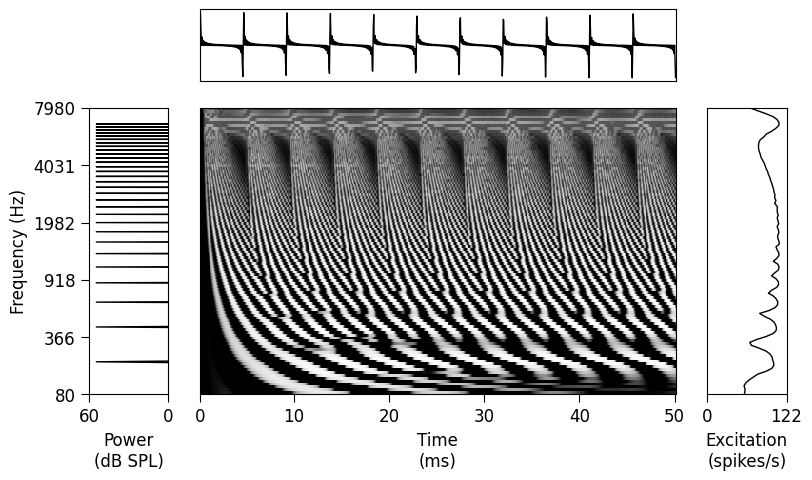

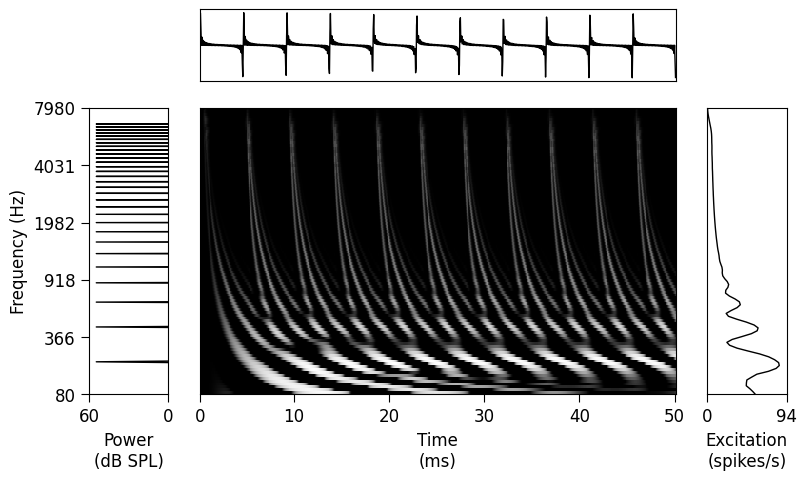

In [12]:
cfs = utils.erbspace(8e1, 8e3, 100)
cochlear_model_healthy = CochlearModel(
    sr_input=sr,
    cfs=cfs,
    compression_power=0.3,
    bw_mult=1,
).to(device)
cochlear_model_impaired = CochlearModel(
    sr_input=sr,
    cfs=cfs,
    # compression_power=np.ones_like(cfs) * 0.7,
    # bw_mult=np.ones_like(cfs) * 2.0,
    compression_power=np.linspace(0.3, 1.0, len(cfs)),
    bw_mult=np.linspace(1.0, 3.0, len(cfs)),
).to(device)

x = utils.harmonic_complex_tone(
    sr=cochlear_model.sr_input,
    dur=0.05,
    f0=220,
    phase="sine",
    harmonics=np.arange(1, 31, 1),
)
x = utils.set_dbspl(x, 70)

x_tensor = torch.as_tensor(x, device=device).float()[None, ...]
x_nervegram_healthy = cochlear_model_healthy(x_tensor)[0].detach().cpu().numpy()
x_nervegram_impaired = cochlear_model_impaired(x_tensor)[0].detach().cpu().numpy()

fig, ax_arr = utils.make_nervegram_plot(
    waveform=x,
    nervegram=x_nervegram_healthy,
    sr_waveform=cochlear_model.sr_input,
    sr_nervegram=cochlear_model.sr_output,
    cfs=cochlear_model.cfs,
)
fig, ax_arr = utils.make_nervegram_plot(
    waveform=x,
    nervegram=x_nervegram_impaired,
    sr_waveform=cochlear_model.sr_input,
    sr_nervegram=cochlear_model.sr_output,
    cfs=cochlear_model.cfs,
)
plt.show()


100%|██████████| 20/20 [00:00<00:00, 149.46it/s]


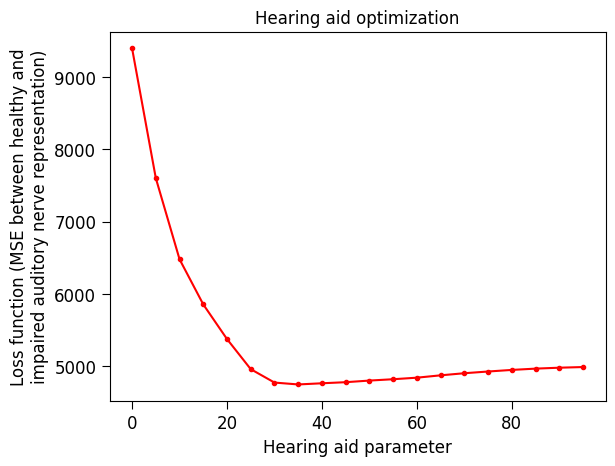

In [15]:
def loss_function(x, x_aided):
    y_healthy = cochlear_model_healthy(x)
    y_impaired = cochlear_model_impaired(x_aided)
    loss = torch.nn.functional.mse_loss(y_impaired, y_healthy)
    return loss

list_db_gain = np.arange(0, 100, 5)
list_loss = []
for db_gain in tqdm.tqdm(list_db_gain):
    amp = np.power(10, db_gain / 20)
    loss = loss_function(x=x_tensor, x_aided=amp * x_tensor).item()
    list_loss.append(loss)

fig, ax = plt.subplots()
ax.plot(list_db_gain, list_loss, marker=".", color="r", ls="-")
utils.format_axes(
    ax,
    str_title="Hearing aid optimization",
    str_xlabel="Hearing aid parameter",
    str_ylabel="Loss function (MSE between healthy and\nimpaired auditory nerve representation)",
)
plt.show()


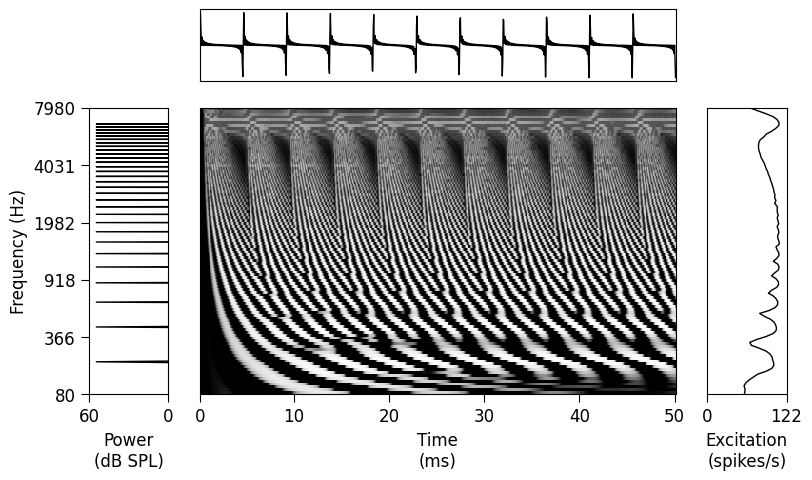

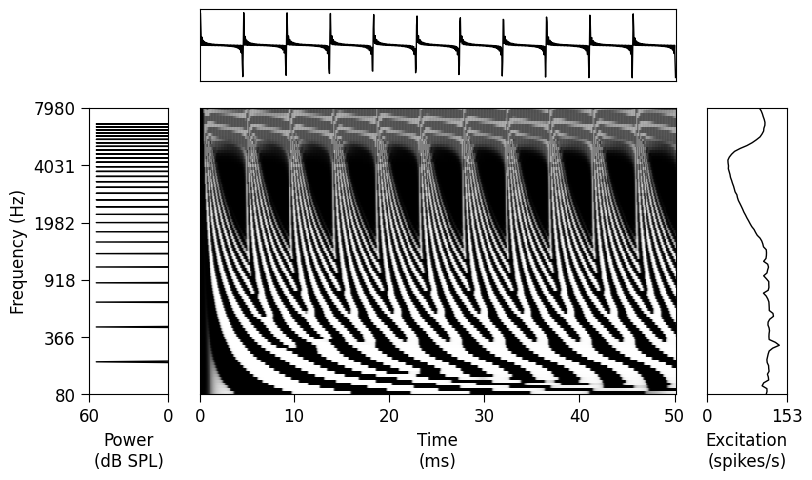

In [16]:
x_tensor = torch.as_tensor(x, device=device).float()[None, ...]
x_nervegram_healthy = cochlear_model_healthy(x_tensor)[0].detach().cpu().numpy()
x_nervegram_impaired = cochlear_model_impaired(np.power(10, 35 / 20) * x_tensor)[0].detach().cpu().numpy()

fig, ax_arr = utils.make_nervegram_plot(
    waveform=x,
    nervegram=x_nervegram_healthy,
    sr_waveform=cochlear_model.sr_input,
    sr_nervegram=cochlear_model.sr_output,
    cfs=cochlear_model.cfs,
)
fig, ax_arr = utils.make_nervegram_plot(
    waveform=x,
    nervegram=x_nervegram_impaired,
    sr_waveform=cochlear_model.sr_input,
    sr_nervegram=cochlear_model.sr_output,
    cfs=cochlear_model.cfs,
)
plt.show()


/content/auditory_model_tutorial/modules.py:248: RuntimeWarning: divide by zero encountered in log
  f = np.log(f)


(7, 20000)


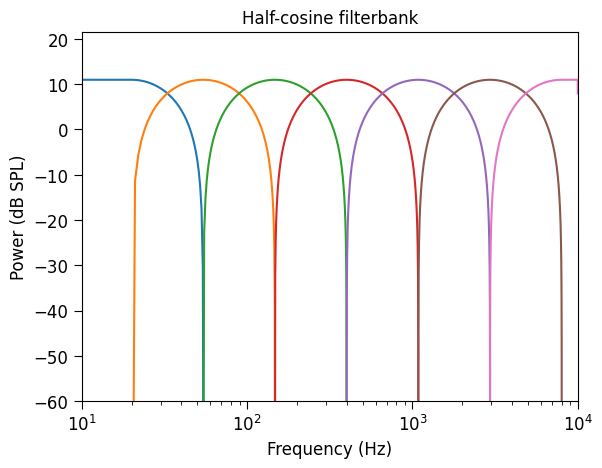

In [17]:
filterbank = modules.HalfCosineFilterbank(
    sr=sr,
    cf_low=20,
    cf_high=8000,
    cf_num=7,
    scale="log",
    include_highpass=True,
    include_lowpass=True,
).to(device)

impulse = np.zeros(int(sr * 1.0))
impulse[0] = 1.0
impulse_tensor = torch.as_tensor(impulse, device=device, dtype=torch.float32).unsqueeze(0)
impulse_response_tensor = filterbank(impulse_tensor).squeeze(0)
impulse_response = impulse_response_tensor.detach().cpu().numpy()
print(impulse_response.shape)

fig, ax = utils.make_periodogram_plot(
    impulse_response,
    sr,
    str_title="Half-cosine filterbank",
)
plt.show()


(20000,)


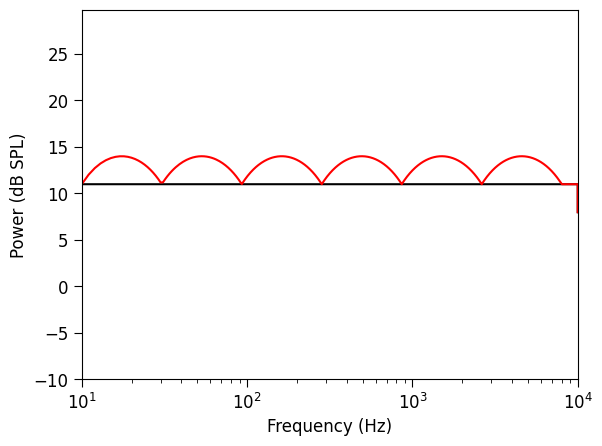

In [32]:
class HearingAid(torch.nn.Module):
    def __init__(self, sr=20e3):
        super().__init__()
        self.filterbank = modules.HalfCosineFilterbank(
            sr=sr,
            cf_low=10,
            cf_high=8000,
            cf_num=7,
            scale="log",
            include_highpass=True,
            include_lowpass=True,
        )
        self.gains = torch.nn.parameter.Parameter(
            data=torch.zeros(self.filterbank.cf_num),
            requires_grad=True,
        )

    def forward(self, x):
        y = self.filterbank(x)
        y = y * torch.pow(10, self.gains / 20).view(1, -1, 1)
        y = torch.sum(y, axis=1)
        return y


hearing_aid = HearingAid(sr=sr).to(device)
# hearing_aid.gains = torch.nn.Parameter(5 * torch.randn(*hearing_aid.gains.shape))

impulse = np.zeros(int(sr * 1.0))
impulse[0] = 1.0
impulse_tensor = torch.as_tensor(impulse, device=device, dtype=torch.float32).unsqueeze(0)
impulse_response_tensor = hearing_aid(impulse_tensor).squeeze(0)
impulse_response = impulse_response_tensor.detach().cpu().numpy()
print(impulse_response.shape)

fig, ax = plt.subplots()
fxx, pxx = utils.periodogram(impulse, sr)
fyy, pyy = utils.periodogram(impulse_response, sr)
ax.plot(fxx, pxx, "k")
ax.plot(fyy, pyy, "r")
utils.format_axes(
    ax,
    xscale="log",
    xlimits=[10, sr / 2],
    ylimits=[-10, None],
    str_xlabel="Frequency (Hz)",
    str_ylabel="Power (dB SPL)",
)
plt.show()


In [33]:
for n, p in hearing_aid.named_parameters():
    print(n, p if p.ndim == 1 else p.shape)

# x = np.stack(
#     [sf.read("data/{:03d}.wav".format(_))[0] for _ in range(4)],
#     axis=0,
# )
# x = torch.as_tensor(x, device=device, dtype=torch.float32)
# x = x[:, 10000:11000]

# torch.manual_seed(0)
# x = torch.randn(1, 500, device=device, dtype=torch.float32)

x = utils.harmonic_complex_tone(
    sr=cochlear_model.sr_input,
    dur=0.05,
    f0=220,
    phase="sine",
    harmonics=np.arange(1, 31, 1),
)
x = utils.set_dbspl(x, 70)
x = torch.as_tensor(x[None, :], device=device, dtype=torch.float32)

print(x.shape)

with torch.autograd.set_detect_anomaly(False):
    num_steps = 1000
    optimizer = torch.optim.Adam(
        params=list(hearing_aid.parameters()),
        lr=1e-1,
    )
    progress_bar = tqdm.tqdm(range(num_steps))
    for step in progress_bar:
        optimizer.zero_grad()
        x_aided = hearing_aid(x)
        loss = loss_function(x=x, x_aided=x_aided)
        loss.backward()
        optimizer.step()
        progress_bar.set_postfix({"loss": "{:0.4f}".format(loss.item())})

for n, p in hearing_aid.named_parameters():
    print(n, p if p.ndim == 1 else p.shape)


gains Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0.], device='cuda:0', requires_grad=True)
torch.Size([1, 1000])


100%|██████████| 1000/1000 [00:07<00:00, 131.03it/s, loss=4420.7954]

gains Parameter containing:
tensor([ -8.9416, -17.1476,  23.5990,  -9.9586,  23.6064,  33.8095,  31.9810],
       device='cuda:0', requires_grad=True)


(20000,)


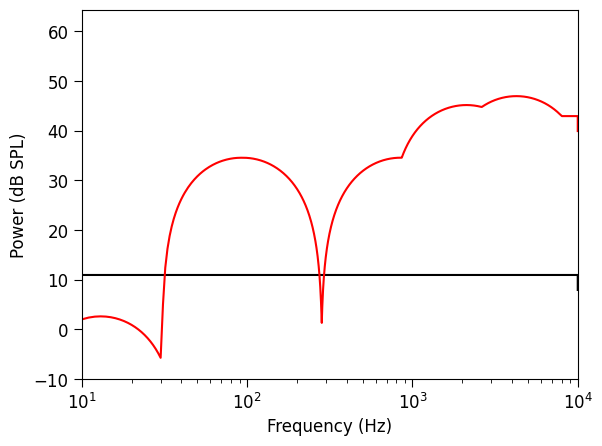

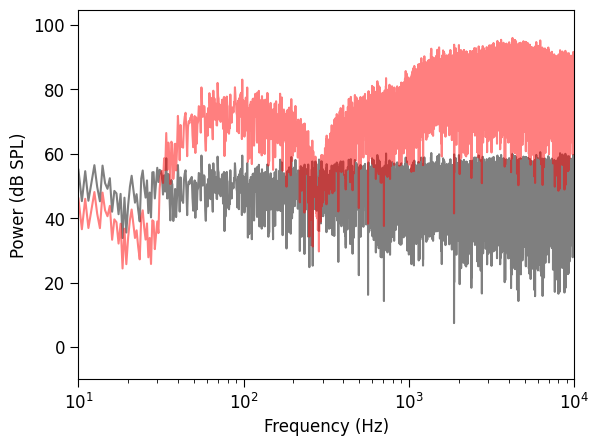

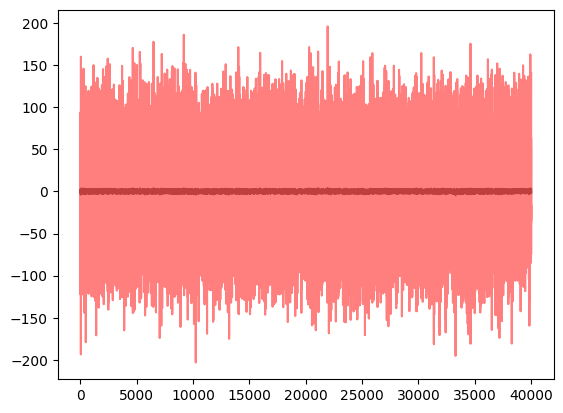

In [34]:
impulse = np.zeros(int(sr * 1.0))
impulse[0] = 1.0
impulse_tensor = torch.as_tensor(impulse, device=device, dtype=torch.float32).unsqueeze(0)
impulse_response_tensor = hearing_aid(impulse_tensor).squeeze(0)
impulse_response = impulse_response_tensor.detach().cpu().numpy()
print(impulse_response.shape)

fig, ax = plt.subplots()
fxx, pxx = utils.periodogram(impulse, sr)
fyy, pyy = utils.periodogram(impulse_response, sr)
ax.plot(fxx, pxx, "k")
ax.plot(fyy, pyy, "r")
utils.format_axes(
    ax,
    xscale="log",
    xlimits=[10, sr / 2],
    ylimits=[-10, None],
    str_xlabel="Frequency (Hz)",
    str_ylabel="Power (dB SPL)",
)
plt.show()


# example_audio = torch.as_tensor(
#     sf.read("data/000.wav".format(_))[0][None, :],
#     device=device,
#     dtype=torch.float32,
# )
example_audio = torch.randn(1, int(2 * sr), device=device, dtype=torch.float32)
example_audio_aided = hearing_aid(example_audio)
example_audio = example_audio[0].detach().cpu().numpy()
example_audio_aided = example_audio_aided[0].detach().cpu().numpy()

ipd.display(ipd.Audio(rate=sr, data=example_audio))
ipd.display(ipd.Audio(rate=sr, data=example_audio_aided))

fig, ax = plt.subplots()
fxx, pxx = utils.periodogram(example_audio, sr)
fyy, pyy = utils.periodogram(example_audio_aided, sr)
ax.plot(fxx, pxx, color="k", alpha=0.5)
ax.plot(fyy, pyy, color="r", alpha=0.5)
utils.format_axes(
    ax,
    xscale="log",
    xlimits=[10, sr / 2],
    ylimits=[-10, None],
    str_xlabel="Frequency (Hz)",
    str_ylabel="Power (dB SPL)",
)
plt.show()

fig, ax = plt.subplots()
ax.plot(example_audio, color="k", alpha=0.5)
ax.plot(example_audio_aided, color="r", alpha=0.5)
plt.show()


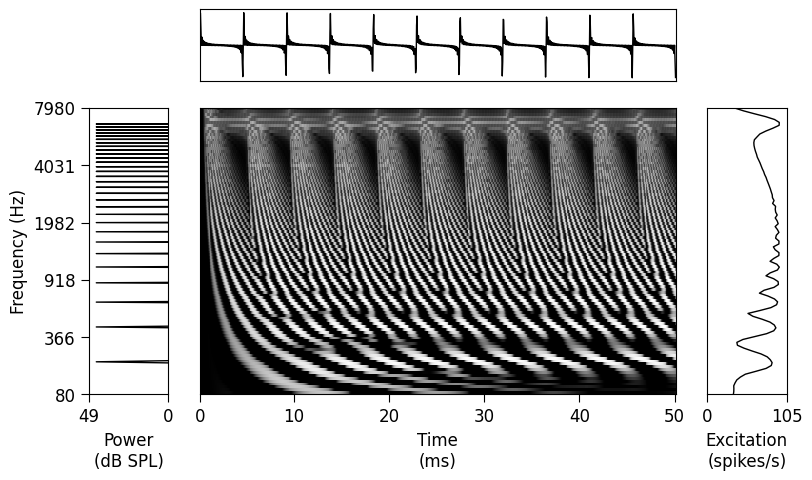

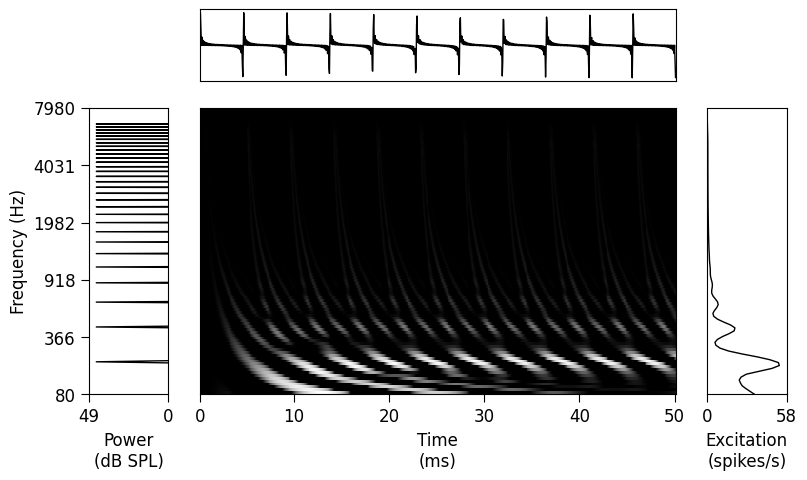

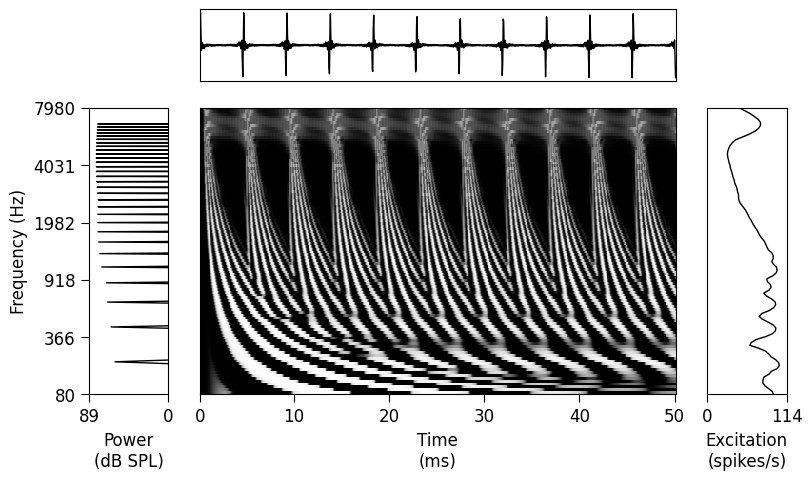

In [35]:
x = utils.harmonic_complex_tone(
    sr=sr,
    dur=0.05,
    f0=220,
    phase="sine",
    harmonics=np.arange(1, 31),
)
# x, _ = sf.read("data/000.wav")
x = utils.set_dbspl(x, 60.0)

x = torch.as_tensor(x[None, ...], dtype=torch.float32, device=device)
x_aided = hearing_aid(x)

nervegram_x = cochlear_model_healthy(x)[0].detach().cpu().numpy()
nervegram_x_impaired = cochlear_model_impaired(x)[0].detach().cpu().numpy()
nervegram_x_impaired_aided = cochlear_model_impaired(x_aided)[0].detach().cpu().numpy()

fig, ax_arr = utils.make_nervegram_plot(
    waveform=x[0].detach().cpu().numpy(),
    nervegram=nervegram_x,
    sr_waveform=cochlear_model_healthy.sr_input,
    sr_nervegram=cochlear_model_healthy.sr_output,
    cfs=cochlear_model_healthy.cfs,
)
fig, ax_arr = utils.make_nervegram_plot(
    waveform=x[0].detach().cpu().numpy(),
    nervegram=nervegram_x_impaired,
    sr_waveform=cochlear_model_impaired.sr_input,
    sr_nervegram=cochlear_model_impaired.sr_output,
    cfs=cochlear_model_impaired.cfs,
)
fig, ax_arr = utils.make_nervegram_plot(
    waveform=x_aided[0].detach().cpu().numpy(),
    nervegram=nervegram_x_impaired_aided,
    sr_waveform=cochlear_model_impaired.sr_input,
    sr_nervegram=cochlear_model_impaired.sr_output,
    cfs=cochlear_model_impaired.cfs,
)
plt.show()


In [ ]:
# fn = "/om2/user/msaddler/phaselocknet/stimuli/spkr_word_recognition/evaluation/human_experiment_v00_foreground60dbspl/stim.hdf5"

# import h5py
# with h5py.File(fn, "r") as f:
#     list_idx = np.logical_and.reduce(
#         [
#             np.isinf(f["snr"][:]),
#             f["background_condition"][:] == 0,
#         ],
#     )
#     list_idx = np.argwhere(list_idx).reshape([-1])
#     for idx in tqdm.tqdm(list_idx):
#         y = f["signal"][idx]
#         sr = f["sr"][idx]
#         foreground_index = f["foreground_index"][idx]
#         fn_wav = "data/{:03.0f}.wav".format(foreground_index)
#         sf.write(
#             file=fn_wav,
#             data=y,
#             samplerate=sr,
#         )
